In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib notebook
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='dark')

from scipy import stats
import numpy as np

from astropy.io import fits
from astropy import cosmology as co
from astropy.stats import median_absolute_deviation, sigma_clipped_stats
from astropy.table import Table
from reproject import reproject_interp, reproject_exact
import astropy.units as u 

import warnings
warnings.filterwarnings('ignore')

z = 1.033

from astropy.cosmology import WMAP9 as cd

In [6]:
hst_header = fits.getheader('../../Data/HST/MACS1206_arc_F105w.fits')
vor_map, _ = reproject_interp('Maps/Map_bins_SN_10_flux_stddev.fits',hst_header,order=0)
vor_map[np.where(vor_map==-1)] = np.nan
amp_map, _  = reproject_interp('../../Data/Lensing/MACS1206/MACS1206_amp.fits',hst_header)

filters = ['F105w','F110w','F125w', 'F140w','F160w','F435w','F606w','F625w','F775w','F814w','F850w']
ZeroPoint = {'F435w' : 25.6663, 'F606w' :26.4941, 'F625w': 25.9002, 'F775w': 25.6628, 'F814w' : 25.9474,
      'F850w': 24.858, 'F105w': 26.2696, 'F110w': 26.8229, 'F125w': 26.231, 'F140w': 26.4531, 'F160w': 25.947}
PhotpLam  = {'F435w' : 4327, 'F606w' : 5922, 'F625w': 6312, 'F775w': 7693, 'F814w' : 8059,
      'F850w': 9033, 'F105w':  10551, 'F110w': 11534, 'F125w': 12486, 'F140w': 13922, 'F160w': 15369}

p, q , listbin = np.loadtxt('bins_SN_10_flux_stddev.txt',unpack=True)
bins = np.unique(listbin)

def measure_photometry(filt):
 
    im = fits.getdata('../../Data/HST/MACS1206_arc_'+filt+'.fits')

    im_std = sigma_clipped_stats(im[50:200,180:210])[2]
    
    amp  = np.array([np.nanmean(amp_map[np.where(vor_map == bin_nb)]) for bin_nb in bins])
    amp_std  = np.array([np.nanstd(amp_map[np.where(vor_map == bin_nb)]) for bin_nb in bins ])
    
    flux = np.array([np.nanmean(im[np.where(vor_map == bin_nb)]) for bin_nb in bins ])
    flux_std = np.array([np.nanstd(im[np.where(vor_map == bin_nb)]) for bin_nb in bins])
    
    pix_nb = np.array([len(np.where(vor_map == bin_nb)[0]) for bin_nb in bins ])
    bg   = np.array([im_std*pix_nb for bin_nb in bins ])
        
    ## Photometry in AB magnitures
    #mag =  -2.5* np.log10(flux/amp) + ZeroPoint[filt] ## in mag AB
    mag =  -2.5* np.log10(flux) + ZeroPoint[filt] ## in mag AB
    mag_err = 2.5/np.log(10) * (flux_std/ flux)
    
    mJy_zp = 23.93 #microJansky (DC: why not 23.90?, I don't know!)
    flux = 10.**(-0.4 * (mag - mJy_zp ))
    flux_err = np.sqrt(flux**2. * (-0.4 * np.log(10.) * mag_err)**2.)
          
    # Check for errors
    if np.any(np.isnan(flux)):
        bad = np.where(np.isnan(flux))
        flux[bad] = -99 # FAST way of saying don't fit
        flux_err[bad] = -99
        
    return flux, flux_err

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

In [7]:
data = map(int,bins)
for filt in filters:
    print('Fitting %s'%filt)
    data = np.vstack((data,measure_photometry(filt)))

Fitting F105w
Fitting F110w
Fitting F125w
Fitting F140w
Fitting F160w
Fitting F435w
Fitting F606w
Fitting F625w
Fitting F775w
Fitting F814w
Fitting F850w


In [9]:
pix_nb = np.array([len(np.where(vor_map == bin_nb)[0]) for bin_nb in bins ])
data_with_z = np.vstack((data,bins*0+z))

t = Table(data_with_z.T,
          names= ['id',
                  'F_F105w','E_F105w','F_F110w','E_F110w','F_F125w','E_F125w', 'F_F140w','E_F140w','F_F160w','E_F160w','F_F435w','E_F435w',
                  'F_F606w','E_F606w','F_F625w','E_F625w','F_F775w','E_F775w','F_F814w','E_F814w','F_F850w','E_F850w',
                   'z_spec'])
t.write('/Users/vera/Desktop/macs1206_photometry.cat',format='ascii.commented_header')
t.write('FAST/macs1206_photometry_no_amp_correction.cat',format='ascii.commented_header')
t.show_in_notebook()

idx,id,F_F105w,E_F105w,F_F110w,E_F110w,F_F125w,E_F125w,F_F140w,E_F140w,F_F160w,E_F160w,F_F435w,E_F435w,F_F606w,E_F606w,F_F625w,E_F625w,F_F775w,E_F775w,F_F814w,E_F814w,F_F850w,E_F850w,z_spec
0,0.0,0.0073238336481153965,0.0009344559512101114,0.009270425885915756,0.0007218145183287561,0.011040224693715572,0.0008361177169717848,0.01314853597432375,0.0010595626663416624,0.015230711549520493,0.0018277784110978246,0.0006327065057121217,0.0010658027604222298,0.0014150984352454543,0.0009858828270807862,0.0016297635156661272,0.0012902241433039308,0.0031808309722691774,0.001702178386040032,0.003976270090788603,0.0014771833084523678,0.005127738695591688,0.001780799706466496,1.033
1,1.0,0.004625322762876749,0.0012604171643033624,0.006030999589711428,0.0017475453205406666,0.007579280063509941,0.00227870000526309,0.008950181305408478,0.002723541809245944,0.010420776903629303,0.0034466702491045,0.00021704558457713574,0.0006388071924448013,0.0004895853344351053,0.0003629495622590184,0.000671816582325846,0.0006166531820781529,0.0015553170815110207,0.0008358543855138123,0.0019246619194746017,0.0006377548561431468,0.002840726636350155,0.001001080498099327,1.033
2,2.0,0.008313539437949657,0.0007138899527490139,0.01007862202823162,0.0010558752110227942,0.011791788972914219,0.001421583816409111,0.013679069466888905,0.001929207006469369,0.01526625920087099,0.002626595553010702,0.0007439579931087792,0.001006128266453743,0.001770396251231432,0.0010410258546471596,0.002021955559030175,0.0011785452952608466,0.003814995987340808,0.00128090288490057,0.004846613388508558,0.0013105496764183044,0.006469573359936476,0.0015016118995845318,1.033
3,3.0,0.005853829439729452,0.0017960128607228398,0.007389238104224205,0.002234462182968855,0.008886401541531086,0.0025724368169903755,0.01009079348295927,0.003167614806443453,0.011509785428643227,0.003792359260842204,0.00036495085805654526,0.0006196903414092958,0.0008205358171835542,0.00045634311391040683,0.0008326196111738682,0.0006244870601221919,0.002235756954178214,0.0009291969472542405,0.0028270052280277014,0.0008644024492241442,0.004041595384478569,0.0015842614229768515,1.033
4,4.0,0.0050066616386175156,0.0009601406054571271,0.006720076315104961,0.0013654715148732066,0.008390822447836399,0.0017334159929305315,0.010226886719465256,0.0025446333456784487,0.012300207279622555,0.0033027655445039272,8.682120824232697e-05,0.0006643918459303677,0.0004222999850753695,0.00032477304921485484,0.00066571548813954,0.0005985529278405011,0.0015406300080940127,0.0008957990212365985,0.0020870270673185587,0.0005657634465023875,0.0031871742103248835,0.0011348322732374072,1.033
5,5.0,0.007479261141270399,0.0006550796679221094,0.009227095171809196,0.000605831213761121,0.011053263209760189,0.001043524593114853,0.013472137041389942,0.0016325569013133645,0.015970226377248764,0.002433584537357092,0.0007508853450417519,0.0009535259450785816,0.0012720951344817877,0.0006810248014517128,0.0014640894951298833,0.0010645418660715222,0.0031461305916309357,0.0013361417222768068,0.003884334350004792,0.0011061686091125011,0.005442531779408455,0.0013080390635877848,1.033
6,6.0,0.005079779773950577,0.0012025116011500359,0.006927710957825184,0.001522163162007928,0.008942210115492344,0.0018789240857586265,0.01077999733388424,0.0028901519253849983,0.012633428908884525,0.0034592137672007084,3.960618778364733e-05,0.0007031427230685949,0.00040564395021647215,0.0003756066143978387,0.0006375106750056148,0.0006909540970809758,0.0016112541779875755,0.0008709948160685599,0.0020473722834140062,0.0007084063836373389,0.003347054123878479,0.0012452121591195464,1.033
7,7.0,0.007509344257414341,0.00045910582412034273,0.009380035102367401,0.00048224220518022776,0.01169542595744133,0.0008644878398627043,0.014160530641674995,0.001175935147330165,0.016731305047869682,0.001867679413408041,0.0004541480739135295,0.000603928929194808,0.0011274636490270495,0.0004322566674090922,0.0015445433091372252,0.0008167685009539127,0.003258919809013605,0.001067643752321601,0.00389349530450

## Read results from fast

In [11]:
fast = Table.read('FAST/macs1206_photometry_no_amp_correction.fout',format='ascii')
fast.show_in_notebook()

idx,id,z,l68_z,u68_z,ltau,l68_ltau,u68_ltau,metal,l68_metal,u68_metal,lage,l68_lage,u68_lage,Av,l68_Av,u68_Av,lmass,l68_lmass,u68_lmass,lsfr,l68_lsfr,u68_lsfr,lssfr,l68_lssfr,u68_lssfr,la2t,l68_la2t,u68_la2t,chi2
0,0,1.03,1.03,1.03,8.5,8.5,10.0,0.004,0.004,0.05,8.0,8.0,9.6,2.4,0.0,3.0,7.27,7.14,8.01,-0.7,-4.06,-0.42,-7.97,-11.69,-7.89,-0.5,-2.0,0.9,0.0641
1,1,1.03,1.03,1.03,9.5,8.5,10.0,0.004,0.004,0.05,9.6,8.0,9.6,1.6,0.0,3.0,7.71,7.14,8.06,-1.94,-6.23,-0.61,-9.65,-13.69,-7.9,0.1,-2.0,1.1,0.0242
2,2,1.03,1.03,1.03,10.0,8.5,10.0,0.008,0.004,0.05,8.4,8.0,9.6,2.1,0.0,2.73,7.38,7.08,7.94,-0.89,-3.14,-0.43,-8.27,-10.47,-7.89,-1.6,-2.0,0.7,0.0559
3,3,1.03,1.03,1.03,8.5,8.5,10.0,0.004,0.004,0.05,8.8,8.0,9.6,1.8,0.0,3.0,7.44,7.11,7.96,-1.67,-6.12,-0.48,-9.12,-13.69,-7.89,0.3,-2.0,1.1,0.0201
4,4,1.03,1.03,1.03,8.5,8.5,10.0,0.004,0.004,0.05,9.0,8.0,9.6,2.0,0.0,3.0,7.67,7.27,8.17,-1.98,-6.1,-0.58,-9.64,-13.69,-7.9,0.5,-2.0,1.1,0.0371
5,5,1.03,1.03,1.03,8.5,8.5,10.0,0.004,0.004,0.05,8.2,8.0,9.6,2.4,0.0,3.0,7.37,7.17,8.06,-0.82,-2.94,-0.35,-8.19,-10.47,-7.89,-0.3,-2.0,0.7,0.0313
6,6,1.03,1.03,1.03,8.5,8.5,10.0,0.004,0.004,0.05,9.0,8.0,9.6,2.1,0.0,3.0,7.72,7.31,8.2,-1.92,-6.08,-0.57,-9.64,-13.69,-7.9,0.5,-2.0,1.1,0.0446
7,7,1.03,1.03,1.03,10.0,8.5,10.0,0.004,0.004,0.05,8.2,8.0,9.6,2.6,0.72,3.0,7.43,7.26,8.08,-0.66,-2.15,-0.34,-8.08,-9.82,-7.89,-1.8,-2.0,0.5,0.141
8,8,1.03,1.03,1.03,8.5,8.5,10.0,0.008,0.004,0.05,8.6,8.0,9.6,1.3,0.0,2.33,7.11,6.8,7.57,-1.63,-2.69,-0.74,-8.74,-9.82,-7.89,0.1,-2.0,0.5,0.052
9,9,1.03,1.03,1.03,9.0,8.5,10.0,0.004,0.004,0.05,9.6,8.26,9.6,1.4,0.23,3.0,8.06,7.66,8.25,-2.4,-5.74,-0.61,-10.45,-13.69,-8.27,0.6,-1.6,1.1,0.0635


Does it add to the mass we had?

In [13]:
tot_mass = np.sum(10**(fast['lmass'])*pix_nb)
print('Total mass of %0.2e mass (from prospector and total (7.87e+10))'%(tot_mass))

Total mass of 2.65e+11 mass (from prospector and total (7.87e+10))


**Convert mass to mass density**

In [14]:
voronoi_map = fits.getdata('Maps/Map_bins_SN_10_flux_stddev.fits')
mass_density_map = np.zeros_like(voronoi_map)
mass_density_map[:,:] = np.nan
mass_density_map_unc = np.zeros_like(voronoi_map)
mass_density_map_unc[:,:] = np.nan
sed_sfr_density_map = np.zeros_like(voronoi_map)
sed_sfr_density_map[:,:] = np.nan
sed_sfr_density_map_unc = np.zeros_like(voronoi_map)
sed_sfr_density_map_unc[:,:] = np.nan

p, q , listbin = np.loadtxt('bins_SN_10_flux_stddev.txt',unpack=True)
bins = np.unique(listbin)

# Conversion
hst_header = fits.getheader('../../Data/HST/MACS1206_arc_F105w.fits')
pix2_to_arcsec2 = (hst_header['CD2_2']*u.deg.to(u.arcsec))**2
arcsec2_to_pc2 = (cd.arcsec_per_kpc_proper(1.033).to(u.arcsec/u.pc).value)**2
to_density = 1. / pix2_to_arcsec2 * arcsec2_to_pc2

amp = []
area_pc = []
size_pc = []

for bin_nb in bins:
    pix = np.where(voronoi_map == bin_nb)
    mass_density_map[voronoi_map == bin_nb] = fast['lmass'][int(bin_nb)] + np.log10(to_density)
    sed_sfr_density_map[voronoi_map == bin_nb] = fast['lsfr'][int(bin_nb)] + np.log10(to_density)
    mass_density_map_unc[voronoi_map == bin_nb] = np.abs(fast['u68_lmass'][int(bin_nb)] - fast['lmass'][int(bin_nb)] )
    sed_sfr_density_map_unc[voronoi_map == bin_nb] = np.abs(fast['u68_lsfr'][int(bin_nb)] - fast['lsfr'][int(bin_nb)] )
    amp.append(np.nanmean(amp_map[np.where(vor_map == bin_nb)]))
    area_pc.append( len(pix[0])**2 * pix2_to_arcsec2 / arcsec2_to_pc2 / amp[-1] ) 
    size_pc.append(np.sqrt(area_pc[-1]))

<IPython.core.display.Javascript object>


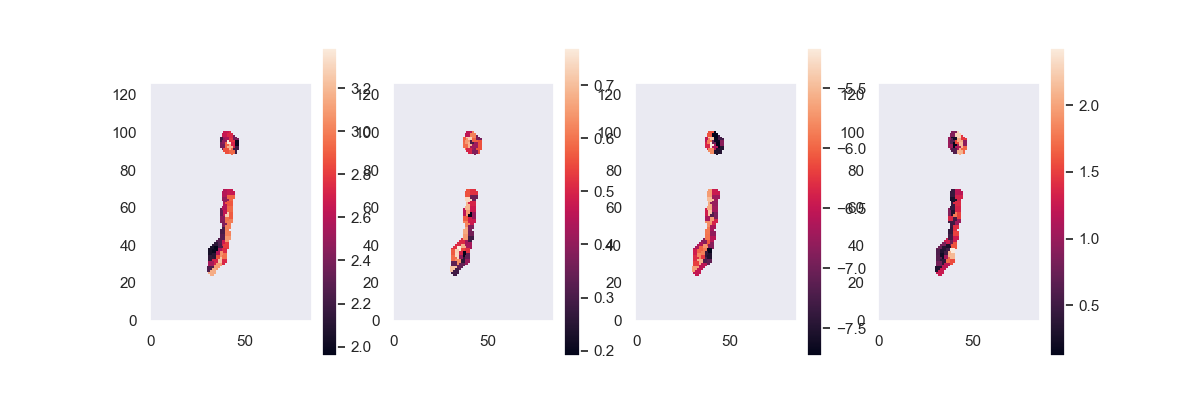

In [15]:
fig, ax = plt.subplots(1,4,figsize=(12,4))
cax = ax[0].imshow(mass_density_map,origin='lower')
plt.colorbar(cax,ax=ax[0])
cax = ax[1].imshow(mass_density_map_unc,origin='lower')
plt.colorbar(cax,ax=ax[1])
cax = ax[2].imshow(sed_sfr_density_map,origin='lower')
plt.colorbar(cax,ax=ax[2])
cax = ax[3].imshow(sed_sfr_density_map_unc,origin='lower')
plt.colorbar(cax,ax=ax[3])

What are the pixel sizes?

<IPython.core.display.Javascript object>


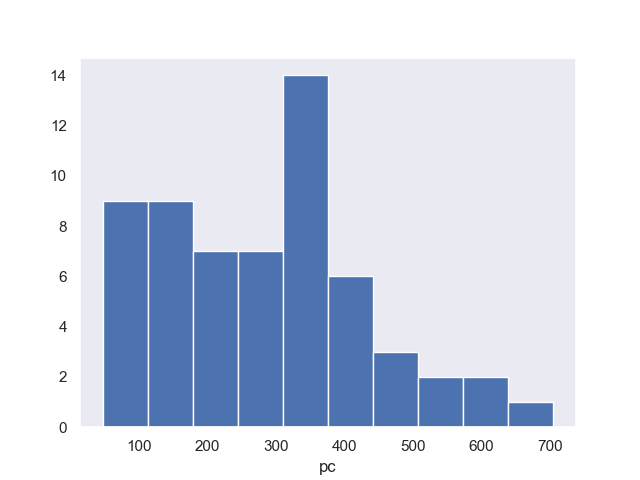

Text(0.5,0,'pc')

In [16]:
plt.figure()
plt.hist(size_pc)
plt.xlabel('pc')

In [17]:
met_map = fits.getdata('Maps/Map_metallicity.fits')
met_map_unc = fits.getdata('Maps/Map_metallicity_unc.fits')

Ha_map = fits.getdata('Maps/Map_Ha_flux_SNR_10.fits')
Ha_map_unc = fits.getdata('Maps/Map_Ha_flux_SNR_10_unc.fits')

voronoi_map[np.where(voronoi_map==-1)] = np.nan
bins = np.unique(voronoi_map)
bins = bins[~np.isnan(bins)]

def measure_in_vbins(im):
    return np.array([sigma_clipped_stats(im[np.where(voronoi_map==v)])[0] for v in bins ])

# Metallicity
met_vbin    = measure_in_vbins(met_map)
met_vbin_unc= measure_in_vbins(met_map_unc)

Ha_vbin    = measure_in_vbins(Ha_map)
Ha_vbin_unc= measure_in_vbins(Ha_map_unc)

dmass_vbin  = measure_in_vbins(mass_density_map) 
dmass_vbin_unc  = measure_in_vbins(mass_density_map_unc) 

dsfr_sed_vbin= measure_in_vbins(sed_sfr_density_map) 
dsfr_sed_vbin_unc= measure_in_vbins(sed_sfr_density_map_unc) 

Save to a table

In [18]:
macs1206 = Table(data=[met_vbin, met_vbin_unc,
                       dsfr_sed_vbin, dsfr_sed_vbin_unc,
                       Ha_vbin,Ha_vbin_unc,
                       dmass_vbin, dmass_vbin_unc,
                       area_pc],
               names=['met','met_unc',
                      'sfr_density_SED','sfr_density_SED_unc',
                      'Ha_flux','Ha_flux_unc',
                      'mass_density','mass_density_unc',
                      'area_pc'])

macs1206.write('../../MainSequence/macs1206_fmz.dat',format='ascii.commented_header')

## Quick look at the results

<IPython.core.display.Javascript object>


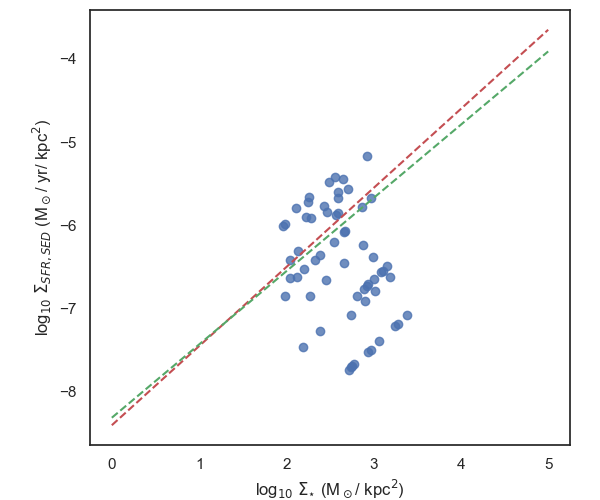

In [19]:
sns.set_style('white')
fig, ax = plt.subplots(1,1,figsize=(6,5))
fig.subplots_adjust(left=0.15,top=0.98,right=0.95)

ax.set_ylabel('log$_{10}$ $\Sigma_{SFR,SED}$ (M$_\odot$/ yr/ kpc$^2$)')
ax.set_xlabel('log$_{10}$ $\Sigma_{\star}$ (M$_\odot$/ kpc$^2$)')
ax.scatter(macs1206['mass_density'],macs1206['sfr_density_SED'],alpha=0.8)

# Plot some relations
def wuytz2013(logmass):
    return -8.4 + 0.95*logmass
def abdurrouf2018(logmass):
    return -8.31 + 0.88*logmass
    
logmass= np.arange(0,5.5,0.5)
ax.plot(logmass,wuytz2013(logmass),'r--')
ax.plot(logmass,abdurrouf2018(logmass),'g--')